In [1]:
import torch
from trl import SFTTrainer
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments

import textwrap
from tabulate import tabulate

train_dataset = load_dataset("tatsu-lab/alpaca", split="train")
print(train_dataset)

pandas_format = train_dataset.to_pandas()

Dataset({
    features: ['instruction', 'input', 'output', 'text'],
    num_rows: 52002
})


In [2]:

# print(tabulate(pandas_format, headers = 'keys', tablefmt = 'psql'))

# print(pandas_format.head())

for index in range(3):
   print("---"*15)
   print("Instruction:\n{}".format(textwrap.fill(pandas_format.iloc[index]["instruction"],
       width=50)))
   print("Output:  \n       {}".format(textwrap.fill(pandas_format.iloc[index]["output"],
       width=50)))
   print("Text: \n       {}".format(textwrap.fill(pandas_format.iloc[index]["text"],
       width=50)))

---------------------------------------------
Instruction:
Give three tips for staying healthy.
Output:  
       1.Eat a balanced diet and make sure to include
plenty of fruits and vegetables.  2. Exercise
regularly to keep your body active and strong.  3.
Get enough sleep and maintain a consistent sleep
schedule.
Text: 
       Below is an instruction that describes a task.
Write a response that appropriately completes the
request.  ### Instruction: Give three tips for
staying healthy.  ### Response: 1.Eat a balanced
diet and make sure to include plenty of fruits and
vegetables.  2. Exercise regularly to keep your
body active and strong.  3. Get enough sleep and
maintain a consistent sleep schedule.
---------------------------------------------
Instruction:
What are the three primary colors?
Output:  
       The three primary colors are red, blue, and
yellow.
Text: 
       Below is an instruction that describes a task.
Write a response that appropriately completes the
request.  ### Ins

In [3]:
display(pandas_format.head())

,instruction,input,output,text
0,Give three tips for staying healthy.,,1.Eat a balanced diet and make sure to include...,Below is an instruction that describes a task....
1,What are the three primary colors?,,"The three primary colors are red, blue, and ye...",Below is an instruction that describes a task....
2,Describe the structure of an atom.,,"An atom is made up of a nucleus, which contain...",Below is an instruction that describes a task....
3,How can we reduce air pollution?,,There are a number of ways to reduce air pollu...,Below is an instruction that describes a task....
4,Describe a time when you had to make a difficu...,,I had to make a difficult decision when I was ...,Below is an instruction that describes a task....


In [4]:
pretrained_model_name = "Salesforce/xgen-7b-8k-base"
model = AutoModelForCausalLM.from_pretrained(pretrained_model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(51200, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-06

In [6]:
tokenizer

XgenTokenizer(name_or_path='Salesforce/xgen-7b-8k-base', vocab_size=51200, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	51200: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

In [7]:
model_training_args = TrainingArguments(
       output_dir="xgen-7b-8k-base-fine-tuned",
       per_device_train_batch_size=4,
       optim="adamw_torch",
       logging_steps=80,
       learning_rate=2e-4,
       warmup_ratio=0.1,
       lr_scheduler_type="linear",
       num_train_epochs=1,
       save_strategy="epoch"
   )

In [8]:
model_training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.NO,
eval_use_gather_object=False,


Matplotlib is building the font cache; this may take a moment.


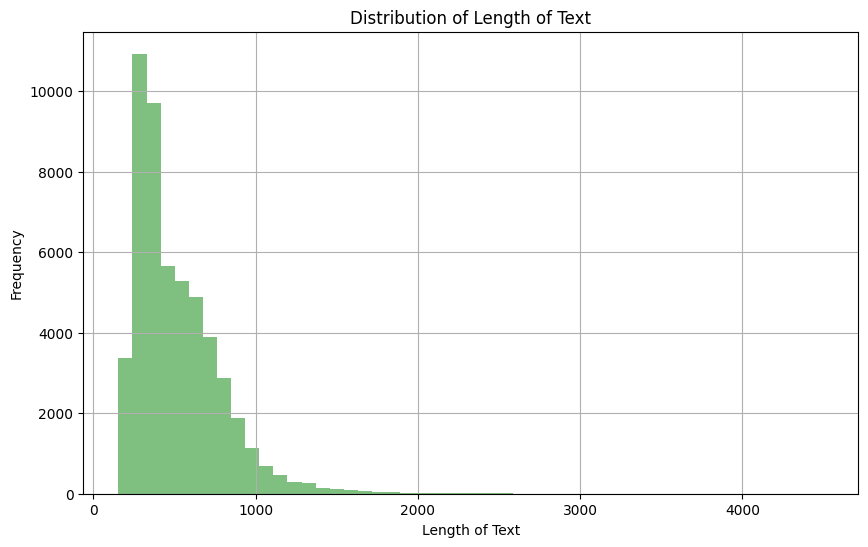

In [10]:
import matplotlib.pyplot as plt


pandas_format['text_length'] = pandas_format['text'].apply(len)


plt.figure(figsize=(10,6))
plt.hist(pandas_format['text_length'], bins=50, alpha=0.5, color='g')
plt.title('Distribution of Length of Text')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [11]:
mask = pandas_format['text_length'] > 1024
percentage = (mask.sum() / pandas_format['text_length'].count()) * 100


print(f"The percentage of text documents with a length greater than 1024 is: {percentage}%")

The percentage of text documents with a length greater than 1024 is: 4.499826929733472%


In [12]:
mask = pandas_format['text_length'] > 1500
percentage = (mask.sum() / pandas_format['text_length'].count()) * 100


print(f"The percentage of text documents with a length greater than 1024 is: {percentage}%")

The percentage of text documents with a length greater than 1024 is: 0.8961193800238453%


In [13]:
for i in range(0, 15):
    mask = pandas_format['text_length'] > i * 100
    percentage = (mask.sum() / pandas_format['text_length'].count()) * 100
    print(f"The percentage of text documents with a length greater than 1024 is: {percentage}%")

The percentage of text documents with a length greater than 1024 is: 100.0%
The percentage of text documents with a length greater than 1024 is: 100.0%
The percentage of text documents with a length greater than 1024 is: 98.49428868120457%
The percentage of text documents with a length greater than 1024 is: 80.14884042921426%
The percentage of text documents with a length greater than 1024 is: 56.09784239067728%
The percentage of text documents with a length greater than 1024 is: 43.0868043536787%
The percentage of text documents with a length greater than 1024 is: 31.416099380793046%
The percentage of text documents with a length greater than 1024 is: 20.887658166993578%
The percentage of text documents with a length greater than 1024 is: 13.149494250221144%
The percentage of text documents with a length greater than 1024 is: 8.04969039652321%
The percentage of text documents with a length greater than 1024 is: 5.0113457174724045%
The percentage of text documents with a length greater

In [14]:
for i in range(0, 15):
    mask_val = i * 100
    mask = pandas_format['text_length'] > mask_val
    percentage = (mask.sum() / pandas_format['text_length'].count()) * 100
    print(f"The percentage of text documents with a length greater than {mask_val} is: {percentage}%")

The percentage of text documents with a length greater than 0 is: 100.0%
The percentage of text documents with a length greater than 100 is: 100.0%
The percentage of text documents with a length greater than 200 is: 98.49428868120457%
The percentage of text documents with a length greater than 300 is: 80.14884042921426%
The percentage of text documents with a length greater than 400 is: 56.09784239067728%
The percentage of text documents with a length greater than 500 is: 43.0868043536787%
The percentage of text documents with a length greater than 600 is: 31.416099380793046%
The percentage of text documents with a length greater than 700 is: 20.887658166993578%
The percentage of text documents with a length greater than 800 is: 13.149494250221144%
The percentage of text documents with a length greater than 900 is: 8.04969039652321%
The percentage of text documents with a length greater than 1000 is: 5.0113457174724045%
The percentage of text documents with a length greater than 1100 i

In [15]:
for i in range(0, 15):
    mask_val = 1500 - i * 20
    mask = pandas_format['text_length'] > mask_val
    percentage = (mask.sum() / pandas_format['text_length'].count()) * 100
    print(f"The percentage of text documents with a length greater than {mask_val} is: {percentage}%")

The percentage of text documents with a length greater than 1500 is: 0.8961193800238453%
The percentage of text documents with a length greater than 1480 is: 0.9480404599823083%
The percentage of text documents with a length greater than 1460 is: 1.0057305488250452%
The percentage of text documents with a length greater than 1440 is: 1.0518826198992348%
The percentage of text documents with a length greater than 1420 is: 1.0999576939348488%
The percentage of text documents with a length greater than 1400 is: 1.173031806468982%
The percentage of text documents with a length greater than 1380 is: 1.2461059190031152%
The percentage of text documents with a length greater than 1360 is: 1.3384100611514942%
The percentage of text documents with a length greater than 1340 is: 1.453790238836968%
The percentage of text documents with a length greater than 1320 is: 1.5614784046767431%
The percentage of text documents with a length greater than 1300 is: 1.6960886119764624%
The percentage of text 

In [16]:
for i in range(0, 15):
    mask_val = 1480 - i
    mask = pandas_format['text_length'] > mask_val
    percentage = (mask.sum() / pandas_format['text_length'].count()) * 100
    print(f"The percentage of text documents with a length greater than {mask_val} is: {percentage}%")

The percentage of text documents with a length greater than 1480 is: 0.9480404599823083%
The percentage of text documents with a length greater than 1479 is: 0.9538094688665821%
The percentage of text documents with a length greater than 1478 is: 0.9576554747894311%
The percentage of text documents with a length greater than 1477 is: 0.9615014807122803%
The percentage of text documents with a length greater than 1476 is: 0.9615014807122803%
The percentage of text documents with a length greater than 1475 is: 0.9653474866351295%
The percentage of text documents with a length greater than 1474 is: 0.9691934925579786%
The percentage of text documents with a length greater than 1473 is: 0.9730394984808276%
The percentage of text documents with a length greater than 1472 is: 0.9768855044036767%
The percentage of text documents with a length greater than 1471 is: 0.9768855044036767%
The percentage of text documents with a length greater than 1470 is: 0.9826545132879505%
The percentage of tex

In [17]:
for i in range(0, 30):
    mask_val = 1470 - (i/20)
    mask = pandas_format['text_length'] > mask_val
    percentage = (mask.sum() / pandas_format['text_length'].count()) * 100
    print(f"The percentage of text documents with a length greater than {mask_val} is: {percentage}%")

The percentage of text documents with a length greater than 1470.0 is: 0.9826545132879505%
The percentage of text documents with a length greater than 1469.95 is: 0.9865005192107996%
The percentage of text documents with a length greater than 1469.9 is: 0.9865005192107996%
The percentage of text documents with a length greater than 1469.85 is: 0.9865005192107996%
The percentage of text documents with a length greater than 1469.8 is: 0.9865005192107996%
The percentage of text documents with a length greater than 1469.75 is: 0.9865005192107996%
The percentage of text documents with a length greater than 1469.7 is: 0.9865005192107996%
The percentage of text documents with a length greater than 1469.65 is: 0.9865005192107996%
The percentage of text documents with a length greater than 1469.6 is: 0.9865005192107996%
The percentage of text documents with a length greater than 1469.55 is: 0.9865005192107996%
The percentage of text documents with a length greater than 1469.5 is: 0.986500519210

In [18]:
mask_val = 1467
mask = pandas_format['text_length'] > mask_val
percentage = (mask.sum() / pandas_format['text_length'].count()) * 100
print(f"The percentage of text documents with a length greater than {mask_val} is: {percentage}%")

The percentage of text documents with a length greater than 1467 is: 0.9941925310564979%


In [19]:
mask_val = 1466
mask = pandas_format['text_length'] > mask_val
percentage = (mask.sum() / pandas_format['text_length'].count()) * 100
print(f"The percentage of text documents with a length greater than {mask_val} is: {percentage}%")

The percentage of text documents with a length greater than 1466 is: 0.9961155340179224%


In [20]:
mask_val = 1465
mask = pandas_format['text_length'] > mask_val
percentage = (mask.sum() / pandas_format['text_length'].count()) * 100
print(f"The percentage of text documents with a length greater than {mask_val} is: {percentage}%")

The percentage of text documents with a length greater than 1465 is: 0.998038536979347%


In [21]:
mask_val = 1464
mask = pandas_format['text_length'] > mask_val
percentage = (mask.sum() / pandas_format['text_length'].count()) * 100
print(f"The percentage of text documents with a length greater than {mask_val} is: {percentage}%")

The percentage of text documents with a length greater than 1464 is: 0.998038536979347%


In [22]:
mask_val = 1463
mask = pandas_format['text_length'] > mask_val
percentage = (mask.sum() / pandas_format['text_length'].count()) * 100
print(f"The percentage of text documents with a length greater than {mask_val} is: {percentage}%")

The percentage of text documents with a length greater than 1463 is: 0.998038536979347%


In [23]:
mask_val = 1462
mask = pandas_format['text_length'] > mask_val
percentage = (mask.sum() / pandas_format['text_length'].count()) * 100
print(f"The percentage of text documents with a length greater than {mask_val} is: {percentage}%")

The percentage of text documents with a length greater than 1462 is: 1.001884542902196%


In [31]:
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
from trl import SFTConfig
lora_peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1
)

In [35]:

training_args = SFTConfig(
    max_seq_length=1462,
    packing=True,
    output_dir="/tmp",
)

trainer = SFTTrainer(
       model=model,
       train_dataset=train_dataset,
       args=training_args,
       processing_class=tokenizer,
       peft_config=lora_peft_config,
   )

Converting train dataset to ChatML:   0%|          | 0/52002 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/52002 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/52002 [00:00<?, ? examples/s]

Packing train dataset:   0%|          | 0/52002 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [38]:
tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_peft_config)
training_args = model_training_args

/Users/christopher.poole/the-oracle/the-oracle/lib/python3.13/site-packages/peft/mapping_func.py:79: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'Salesforce/xgen-7b-8k-base' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(


In [39]:

trainer.train()

/Users/christopher.poole/the-oracle/the-oracle/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


RuntimeError: MPS backend out of memory (MPS allocated: 34.72 GB, other allocations: 434.67 MB, max allowed: 36.27 GB). Tried to allocate 2.04 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [40]:
help(trainer)

Help on SFTTrainer in module trl.trainer.sft_trainer object:

class SFTTrainer(transformers.trainer.Trainer)
 |  SFTTrainer(
 |      model: Union[str, torch.nn.modules.module.Module, transformers.modeling_utils.PreTrainedModel],
 |      args: Union[trl.trainer.sft_config.SFTConfig, transformers.training_args.TrainingArguments, NoneType] = None,
 |      data_collator: Optional[transformers.data.data_collator.DataCollator] = None,
 |      train_dataset: Union[datasets.arrow_dataset.Dataset, datasets.iterable_dataset.IterableDataset, NoneType] = None,
 |      eval_dataset: Union[datasets.arrow_dataset.Dataset, dict[str, datasets.arrow_dataset.Dataset], NoneType] = None,
 |      processing_class: Union[transformers.tokenization_utils_base.PreTrainedTokenizerBase, transformers.utils.dummy_vision_objects.BaseImageProcessor, transformers.feature_extraction_utils.FeatureExtractionMixin, transformers.processing_utils.ProcessorMixin, NoneType] = None,
 |      compute_loss_func: Optional[Callable